### Heatmap visualisation 

##### At this point in manuscript analysis, we will:
- Load in embryo cells of interest (log normalised)
- Plot some cell state defining markers, or some other relevant/interesting markers

#### 2GB RAM used

# 1 - Import packages

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy.stats
import anndata
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from scipy import sparse

pd.set_option('display.max_rows', 1000000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Set up for plotting and warnings
matplotlib_axes_logger.setLevel('ERROR')
warnings.filterwarnings("ignore")
sc.settings.verbosity = 0  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=120, dpi_save=1000)
sc.logging.print_header()

scanpy==1.9.3 anndata==0.9.1 umap==0.5.3 numpy==1.23.5 scipy==1.10.1 pandas==2.0.2 scikit-learn==1.2.2 statsmodels==0.14.0 python-igraph==0.10.4 pynndescent==0.5.10


# 2 - Define paths and configs

In [2]:
# define date
date = '20240808'

# define ouput file paths
outputs_resources = '/lustre/scratch126/cellgen/team298/sw33/meninges/resources/heatmaps/' # i will save excels, etc, here
outputs_figs = '/lustre/scratch126/cellgen/team298/sw33/meninges/figures/heatmaps/' # i will save output figures here
sc.settings.figdir = outputs_figs # just making sure scanpy umaps, etc, are saved alongside the rest of my figs

# define input file paths
adata_path = "/lustre/scratch126/cellgen/team298/sw33/meninges/data/Recombined3Clean2_IMM_Lymphoid_B.h5ad" # this is a hardcoded filepath to the raw n=3 embryo object

# define the subset of the data we will subset to. if no subsetting is needed, just set subsetting_required = False, and subsetting_metadata_col/cats to None
subsetting_required = False
subsetting_metadata_col = None                               
subsetting_metadata_cats = None     

# define title, columns and ordered categories for the dotplot plotting. these are required
heatmap_title = "meninges_Bcell_markers_by_age_in_cs"
plotting_metadata_col = 'Agepool'                                
plotting_metadata_cats = [5, 6, 7, 8, 10, 13]

# give gene dictionary and vmax for dotplots
gene_dict = {
# here are some B lineage markers from fetal bone marrow - ExtFig4E - https://www.nature.com/articles/s41586-021-03929-x/figures/7
    "HSPCs-ELP-preproB-proB": ['CD34', 'SPINK2', 'MLLT3'], 
    "prepropB": ['IL7R', 'CDC45', 'DHFR', 'UHRF1'], 
    "proB": ['DNTT'], #'VPREB1'
    "preB": ['IDH2'], 
    "immature B": ['CD19', 'SPIB', 'IGHD', 'CD40', 'FCER2'], # 'IGHM',
    "naive B": ["MS4A1"]
}

vmax_setting=2

# if we are merging 2x adata.obs columns for groupings in dotplot, please define these here 
merge_cols= False
merge_col_names = []
merged_col_name = ''

# 3 - Import data 

In [3]:
adata = sc.read(adata_path)  

In [4]:
adata

AnnData object with n_obs × n_vars = 26 × 33538
    obs: 'Age', 'Agepool', 'Agetext', 'Ageunit', 'All_fc_analysis_id', 'Analysis', 'Cellconc', 'Cellcycle', 'Cellcycle_g1', 'Cellcycle_g2m', 'Cellcycle_s', 'Cellcyclescore', 'Chemistry', 'Classann', 'Clusters', 'Clusterscollected', 'Clustertext', 'Cmobarcodes', 'Comment', 'Config', 'Creationdate_cells', 'Datecaptured', 'Donor', 'Doubletfinderflag', 'Doubletfinderscore', 'Editat', 'Editby', 'Id', 'Iscycling', 'Label', 'Meanage', 'Meantotalumi', 'Method', 'Mt_ratio', 'Name', 'Neuronprop', 'Newclusters', 'Ngenes', 'Numpooledanimals', 'Oldclusters', 'Oldclustersrecomb2', 'Ordering', 'Originalsubset', 'Outliers', 'Passedqc', 'Passedqc_mt_ratio', 'Passedqc_totalumi', 'Passedqc_umipergene', 'Passedqc_unsplicedratio', 'Plugdate', 'Project', 'Radius', 'Recombined3clean2clusters', 'Roi', 'Sampleid', 'Sampleok', 'Sex', 'Shortname', 'Souporcell', 'Species', 'Split', 'Strain', 'Subclass', 'Subset', 'Superclass', 'Targetnumcells', 'Tissue', 'Tissueclas

In [5]:
adata.shape

(26, 33538)

In [6]:
adata.obs[:3]

,Age,Agepool,Agetext,Ageunit,All_fc_analysis_id,Analysis,Cellconc,Cellcycle,Cellcycle_g1,Cellcycle_g2m,Cellcycle_s,Cellcyclescore,Chemistry,Classann,Clusters,Clusterscollected,Clustertext,Cmobarcodes,Comment,Config,Creationdate_cells,Datecaptured,Donor,Doubletfinderflag,Doubletfinderscore,Editat,Editby,Id,Iscycling,Label,Meanage,Meantotalumi,Method,Mt_ratio,Name,Neuronprop,Newclusters,Ngenes,Numpooledanimals,Oldclusters,Oldclustersrecomb2,Ordering,Originalsubset,Outliers,Passedqc,Passedqc_mt_ratio,Passedqc_totalumi,Passedqc_umipergene,Passedqc_unsplicedratio,Plugdate,Project,Radius,Recombined3clean2clusters,Roi,Sampleid,Sampleok,Sex,Shortname,Souporcell,Species,Split,Strain,Subclass,Subset,Superclass,Targetnumcells,Tissue,Tissueclass,Totalumi,Transcriptome,Unspliced_ratio,Velocyto___version__,Velocyto_logic,X__x,X__y
Cellid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10X231_3_AB_1:GACGTTAAGGGTCTTTx,6.7,6,6.7w,pcw,7547,Queueing,1010,0.028776,0.005642,0.015986,0.007147,34.615385,v3,Lymphoid,2,5,B cell & Plasma cell,,"GA 7w4, CRL 19 NRL 10 (PCW 6w5d)",paths:\n build: /proj/meninges/OLD_REF_NoPOIS...,20191126T155201.277139Z,2019-10-16,BRC2218,0,0.28,2021-07-06 14:10:19,elin,1165,1,,8.923077,0.985117,rna-seq,0.044198,10X231_3,N/A,116,2213.0,,2,259,157,Meninges_Immune.loom,0,1,0,1,0,1,,Elin,0.607191,182,,Recombined3_Clean,Y,,BRC2218,singlet-0,Hs,3,,B cell & Plasma cell,IMM,Immune,5000,Meninges,Meninges,5317.0,GRCh38-3.0.0,0.242994,0.17.11,Default,-37.204704,-0.323619
10X297_5_AB_1:AAAGGTATCATGCATGx,5.5,5,5.5w,pcw,7541,Queueing,290,0.001898,0.000211,0.001055,0.000633,34.615385,v3,Lymphoid,2,5,B cell & Plasma cell,,,paths:\n build: /proj/meninges/OLD_REF_NoPOIS...,20210113T220616.045868Z,2020-10-21,XDD400,0,0.04,2023-06-17 14:55:04,elin,1493,0,,8.923077,0.447177,rna-seq,0.029108,10X297_5,N/A,116,2041.0,,2,259,145,Meninges_Immune.loom,0,1,0,0,0,0,,Elin,0.607191,182,,Recombined3_Clean,N/A,,XDD400,singlet-0,Hs,3,,B cell & Plasma cell,IMM,Immune,5000,Meninges,Meninges,4741.0,GRCh38-3.0.0,0.209028,0.17.17,Default,-18.416475,8.136704
10X297_5_AB_1:AAAGTGACAAGACAATx,5.5,5,5.5w,pcw,7541,Queueing,290,0.004331,0.001444,0.001925,0.000962,34.615385,v3,Lymphoid,2,5,B cell & Plasma cell,,,paths:\n build: /proj/meninges/OLD_REF_NoPOIS...,20210113T220616.045868Z,2020-10-21,XDD400,0,0.00,2023-06-17 14:55:04,elin,1493,0,,8.923077,0.447177,rna-seq,0.020693,10X297_5,N/A,116,1067.0,,2,259,146,Meninges_Immune.loom,0,1,0,0,0,0,,Elin,0.607191,182,,Recombined3_Clean,N/A,,XDD400,singlet-0,Hs,3,,B cell & Plasma cell,IMM,Immune,5000,Meninges,Meninges,2078.0,GRCh38-3.0.0,0.235804,0.17.17,Default,11.312424,31.075649


In [7]:
adata.var['Accession']=adata.var.index
adata.var_names=adata.var['Gene'].astype(str)
print(adata.shape)
adata.var[:3]
adata.var_names_make_unique()
print(adata.shape)

(26, 33538)
(26, 33538)


In [8]:
# have a look at number of cells by donor / biological replicate
cell_numbers = adata.obs.groupby(["Subclass"]).apply(len)
cell_numbers

Subclass
B cell & Plasma cell    26
dtype: int64

In [9]:
# have a look at number of cells
cell_numbers = adata.obs.groupby(["Agepool"]).apply(len)
cell_numbers

Agepool
5     9
6     3
7     3
8     1
10    1
13    9
dtype: int64

In [10]:
# have a look at number of cells
cell_numbers = adata.obs.groupby(["Donor"]).apply(len)
cell_numbers

Donor
BRC2218    2
BRC2226    1
BRC2227    1
BRC2243    1
BRC2301    1
XDD385     9
XDD399     1
XDD400     9
XHU364     1
dtype: int64

In [11]:
# have a look at number of cells
cell_numbers = adata.obs.groupby(["Agepool", "Donor"]).apply(len)
cell_numbers

Agepool  Donor  
5        XDD400     9
6        BRC2218    2
         BRC2243    1
7        BRC2227    1
         XDD399     1
         XHU364     1
8        BRC2226    1
10       BRC2301    1
13       XDD385     9
dtype: int64

In [12]:
# have a look at number of cells
cell_numbers = adata.obs.groupby(["Agepool", "Donor", "Subclass"]).apply(len)
cell_numbers

Agepool  Donor    Subclass            
5        XDD400   B cell & Plasma cell    9
6        BRC2218  B cell & Plasma cell    2
         BRC2243  B cell & Plasma cell    1
7        BRC2227  B cell & Plasma cell    1
         XDD399   B cell & Plasma cell    1
         XHU364   B cell & Plasma cell    1
8        BRC2226  B cell & Plasma cell    1
10       BRC2301  B cell & Plasma cell    1
13       XDD385   B cell & Plasma cell    9
dtype: int64

# 4 - Subset the data 

In [13]:
if subsetting_required == True:
    adata = adata[adata.obs[subsetting_metadata_col].isin(subsetting_metadata_cats)].copy()

In [14]:
adata

AnnData object with n_obs × n_vars = 26 × 33538
    obs: 'Age', 'Agepool', 'Agetext', 'Ageunit', 'All_fc_analysis_id', 'Analysis', 'Cellconc', 'Cellcycle', 'Cellcycle_g1', 'Cellcycle_g2m', 'Cellcycle_s', 'Cellcyclescore', 'Chemistry', 'Classann', 'Clusters', 'Clusterscollected', 'Clustertext', 'Cmobarcodes', 'Comment', 'Config', 'Creationdate_cells', 'Datecaptured', 'Donor', 'Doubletfinderflag', 'Doubletfinderscore', 'Editat', 'Editby', 'Id', 'Iscycling', 'Label', 'Meanage', 'Meantotalumi', 'Method', 'Mt_ratio', 'Name', 'Neuronprop', 'Newclusters', 'Ngenes', 'Numpooledanimals', 'Oldclusters', 'Oldclustersrecomb2', 'Ordering', 'Originalsubset', 'Outliers', 'Passedqc', 'Passedqc_mt_ratio', 'Passedqc_totalumi', 'Passedqc_umipergene', 'Passedqc_unsplicedratio', 'Plugdate', 'Project', 'Radius', 'Recombined3clean2clusters', 'Roi', 'Sampleid', 'Sampleok', 'Sex', 'Shortname', 'Souporcell', 'Species', 'Split', 'Strain', 'Subclass', 'Subset', 'Superclass', 'Targetnumcells', 'Tissue', 'Tissueclas

In [15]:
adata.shape

(26, 33538)

In [16]:
adata.obs[:3]

,Age,Agepool,Agetext,Ageunit,All_fc_analysis_id,Analysis,Cellconc,Cellcycle,Cellcycle_g1,Cellcycle_g2m,Cellcycle_s,Cellcyclescore,Chemistry,Classann,Clusters,Clusterscollected,Clustertext,Cmobarcodes,Comment,Config,Creationdate_cells,Datecaptured,Donor,Doubletfinderflag,Doubletfinderscore,Editat,Editby,Id,Iscycling,Label,Meanage,Meantotalumi,Method,Mt_ratio,Name,Neuronprop,Newclusters,Ngenes,Numpooledanimals,Oldclusters,Oldclustersrecomb2,Ordering,Originalsubset,Outliers,Passedqc,Passedqc_mt_ratio,Passedqc_totalumi,Passedqc_umipergene,Passedqc_unsplicedratio,Plugdate,Project,Radius,Recombined3clean2clusters,Roi,Sampleid,Sampleok,Sex,Shortname,Souporcell,Species,Split,Strain,Subclass,Subset,Superclass,Targetnumcells,Tissue,Tissueclass,Totalumi,Transcriptome,Unspliced_ratio,Velocyto___version__,Velocyto_logic,X__x,X__y
Cellid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10X231_3_AB_1:GACGTTAAGGGTCTTTx,6.7,6,6.7w,pcw,7547,Queueing,1010,0.028776,0.005642,0.015986,0.007147,34.615385,v3,Lymphoid,2,5,B cell & Plasma cell,,"GA 7w4, CRL 19 NRL 10 (PCW 6w5d)",paths:\n build: /proj/meninges/OLD_REF_NoPOIS...,20191126T155201.277139Z,2019-10-16,BRC2218,0,0.28,2021-07-06 14:10:19,elin,1165,1,,8.923077,0.985117,rna-seq,0.044198,10X231_3,N/A,116,2213.0,,2,259,157,Meninges_Immune.loom,0,1,0,1,0,1,,Elin,0.607191,182,,Recombined3_Clean,Y,,BRC2218,singlet-0,Hs,3,,B cell & Plasma cell,IMM,Immune,5000,Meninges,Meninges,5317.0,GRCh38-3.0.0,0.242994,0.17.11,Default,-37.204704,-0.323619
10X297_5_AB_1:AAAGGTATCATGCATGx,5.5,5,5.5w,pcw,7541,Queueing,290,0.001898,0.000211,0.001055,0.000633,34.615385,v3,Lymphoid,2,5,B cell & Plasma cell,,,paths:\n build: /proj/meninges/OLD_REF_NoPOIS...,20210113T220616.045868Z,2020-10-21,XDD400,0,0.04,2023-06-17 14:55:04,elin,1493,0,,8.923077,0.447177,rna-seq,0.029108,10X297_5,N/A,116,2041.0,,2,259,145,Meninges_Immune.loom,0,1,0,0,0,0,,Elin,0.607191,182,,Recombined3_Clean,N/A,,XDD400,singlet-0,Hs,3,,B cell & Plasma cell,IMM,Immune,5000,Meninges,Meninges,4741.0,GRCh38-3.0.0,0.209028,0.17.17,Default,-18.416475,8.136704
10X297_5_AB_1:AAAGTGACAAGACAATx,5.5,5,5.5w,pcw,7541,Queueing,290,0.004331,0.001444,0.001925,0.000962,34.615385,v3,Lymphoid,2,5,B cell & Plasma cell,,,paths:\n build: /proj/meninges/OLD_REF_NoPOIS...,20210113T220616.045868Z,2020-10-21,XDD400,0,0.00,2023-06-17 14:55:04,elin,1493,0,,8.923077,0.447177,rna-seq,0.020693,10X297_5,N/A,116,1067.0,,2,259,146,Meninges_Immune.loom,0,1,0,0,0,0,,Elin,0.607191,182,,Recombined3_Clean,N/A,,XDD400,singlet-0,Hs,3,,B cell & Plasma cell,IMM,Immune,5000,Meninges,Meninges,2078.0,GRCh38-3.0.0,0.235804,0.17.17,Default,11.312424,31.075649


In [17]:
adata.var[:3]

,Chromosome,End,Gene,Selected,Start,Strand,Valid,Accession
Gene,,,,,,,,
GPC5,13,92873682,GPC5,1,91398607,+,1,ENSG00000179399
NLGN1,3,174286644,NLGN1,1,173396284,+,1,ENSG00000169760
RIPOR3,20,50691528,RIPOR3,1,50586108,-,1,ENSG00000042062


In [18]:
# have a look at number of cells by donor / biological replicate
cell_numbers = adata.obs.groupby(["Subclass"]).apply(len)
cell_numbers

Subclass
B cell & Plasma cell    26
dtype: int64

In [19]:
# have a look at number of cells
cell_numbers = adata.obs.groupby(["Agepool"]).apply(len)
cell_numbers

Agepool
5     9
6     3
7     3
8     1
10    1
13    9
dtype: int64

In [20]:
# have a look at number of cells
cell_numbers = adata.obs.groupby(["Donor"]).apply(len)
cell_numbers

Donor
BRC2218    2
BRC2226    1
BRC2227    1
BRC2243    1
BRC2301    1
XDD385     9
XDD399     1
XDD400     9
XHU364     1
dtype: int64

In [21]:
# have a look at number of cells
cell_numbers = adata.obs.groupby(["Agepool", "Donor"]).apply(len)
cell_numbers

Agepool  Donor  
5        XDD400     9
6        BRC2218    2
         BRC2243    1
7        BRC2227    1
         XDD399     1
         XHU364     1
8        BRC2226    1
10       BRC2301    1
13       XDD385     9
dtype: int64

In [22]:
# have a look at number of cells
cell_numbers = adata.obs.groupby(["Agepool", "Donor", "Subclass"]).apply(len)
cell_numbers

Agepool  Donor    Subclass            
5        XDD400   B cell & Plasma cell    9
6        BRC2218  B cell & Plasma cell    2
         BRC2243  B cell & Plasma cell    1
7        BRC2227  B cell & Plasma cell    1
         XDD399   B cell & Plasma cell    1
         XHU364   B cell & Plasma cell    1
8        BRC2226  B cell & Plasma cell    1
10       BRC2301  B cell & Plasma cell    1
13       XDD385   B cell & Plasma cell    9
dtype: int64

# 5 - Log-normalise the data

In [23]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

In [24]:
sc.pp.log1p(adata)

# 6 - Update cell state label ordering

In [25]:
if merge_cols == True:
    adata.obs[merged_col_name] = adata.obs[merge_col_names[0]].astype(str) + "_" + adata.obs[merge_col_names[1]].astype(str)
    plotting_metadata_col = merged_col_name

In [26]:
adata.obs[plotting_metadata_col] = adata.obs[plotting_metadata_col].astype('category')
adata.obs[plotting_metadata_col] = adata.obs[plotting_metadata_col].cat.reorder_categories(plotting_metadata_cats)
adata.obs[plotting_metadata_col].cat.categories

Index([5, 6, 7, 8, 10, 13], dtype='int64')

# 7 - Run heatmap

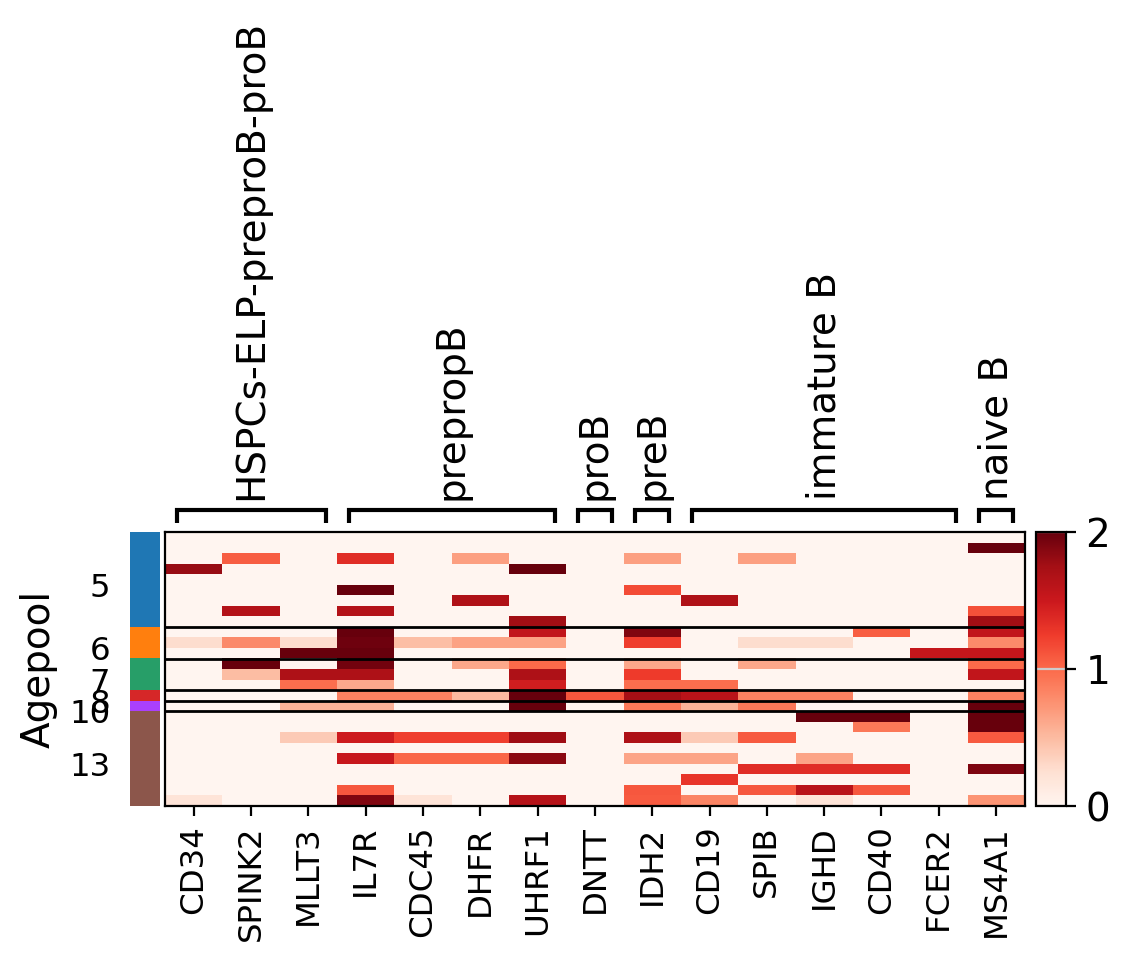

In [27]:
sc.settings.set_figure_params(dpi=100, dpi_save=1000)
sc.pl.heatmap(adata, var_names=gene_dict, save=f"_{heatmap_title}_{date}.pdf", 
              use_raw=False, swap_axes=False, figsize=(6,2), cmap ='Reds', vmax=vmax_setting, groupby=plotting_metadata_col)  

# 8 - Run dotplot

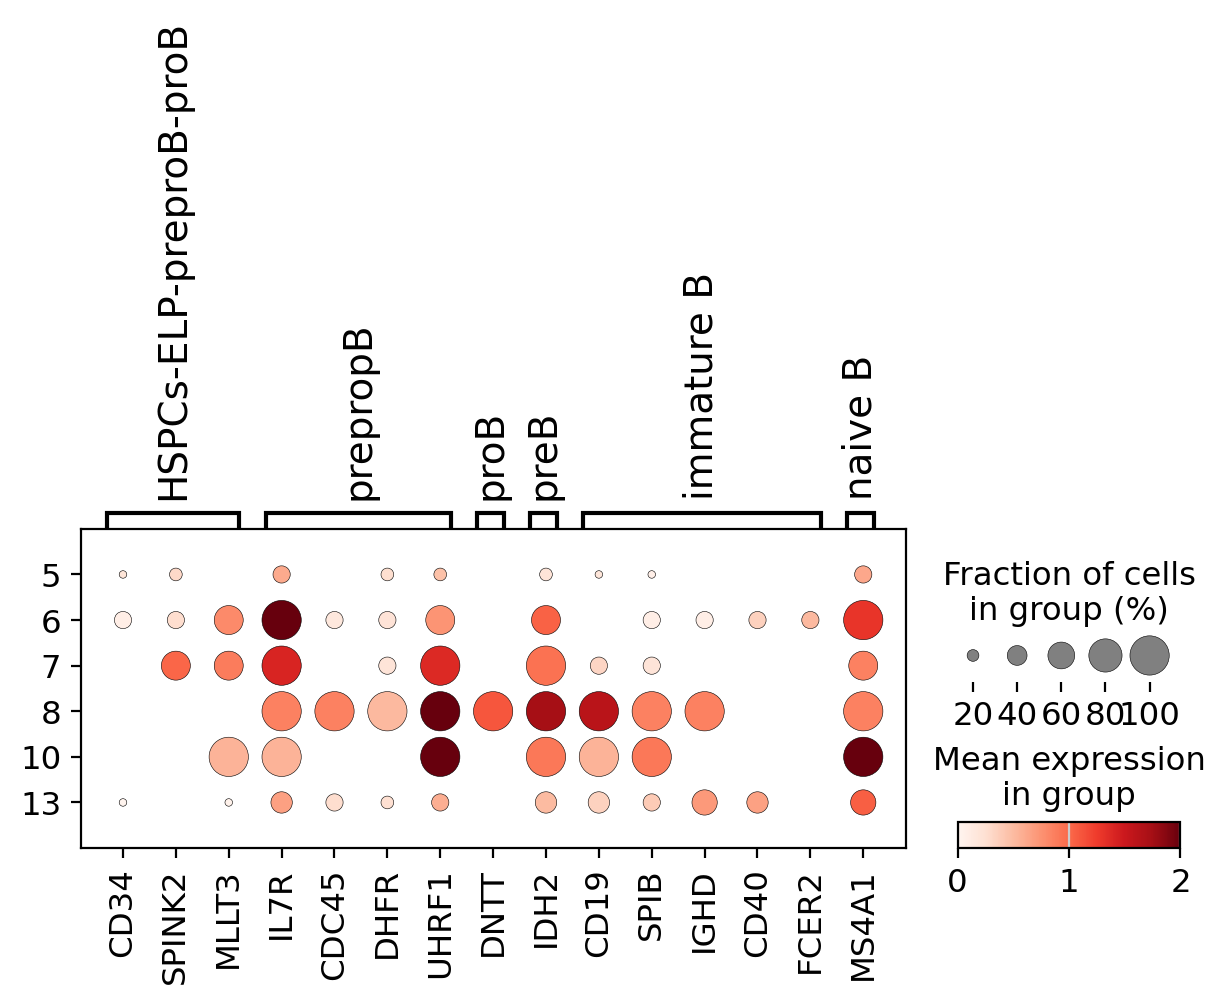

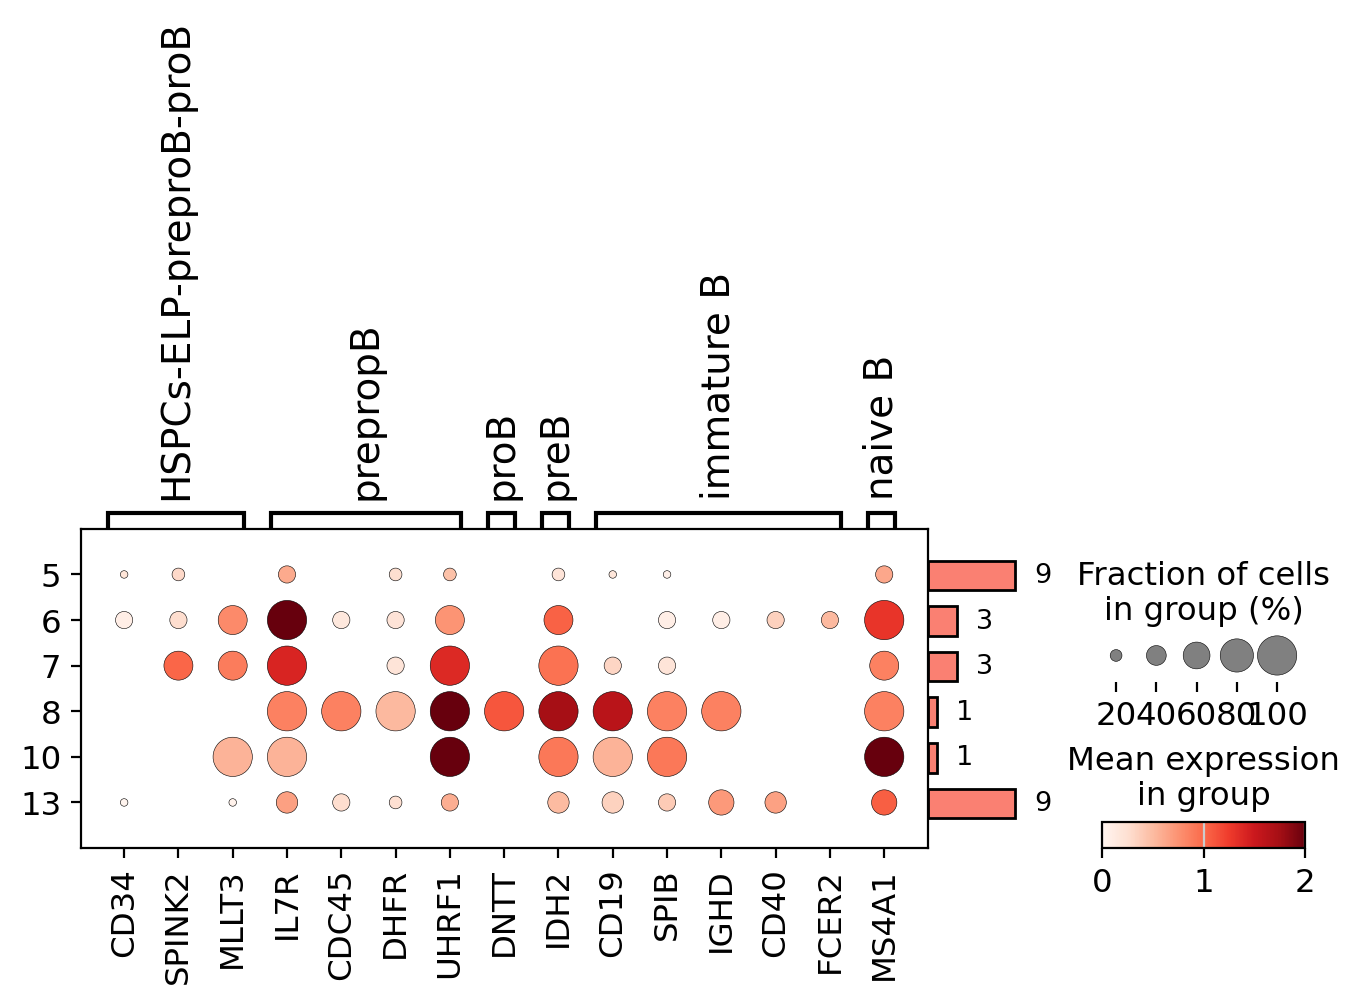

In [28]:
outputs_resources = '/lustre/scratch126/cellgen/team298/sw33/meninges/resources/dotplots/' # i will save excels, etc, here
outputs_figs = '/lustre/scratch126/cellgen/team298/sw33/meninges/figures/dotplots/' # i will save output figures here
dotplot_title="meninges_Bcell_markers_by_age_in_cs"

sc.settings.set_figure_params(dpi=100, dpi_save=1000)
sc.pl.dotplot(adata, var_names=gene_dict, save=f"WE_{dotplot_title}_{date}.pdf",
              groupby=plotting_metadata_col, use_raw=False, vmax=vmax_setting)

dp = sc.pl.dotplot(adata, var_names=gene_dict, 
              groupby=plotting_metadata_col, use_raw=False, vmax=vmax_setting, return_fig=True)
dp.add_totals()
dp.savefig(outputs_figs + f"WE_{dotplot_title}_withpops_{date}.pdf")